# Сбор фичей

Cобираем все данные (исходную таблицу и сгенерированные фичи) вместе и делим на тренировочную, валидационную и тестовую выборки в двух вариантах: со сбалансированными и несбалансированными классами

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
import numpy as np

import re

In [154]:
data = "../data/wb_school_task_2.csv.gzip"
data = pd.read_csv(data, compression='gzip')
data = data.drop_duplicates(ignore_index=True)

In [82]:
#data = data.drop(['f2', 'f4'], axis=1)

## Общие текстовые фичи

In [155]:
def extract_features(s: pd.Series):
    text = s['text']
    word_count = len(re.findall(r'[а-яА-Яa-zA-Z]+', text))
    # есть отзывы, состоящие из смайликов, пробелов или нижних подчеркиваний
    if word_count == 0:
            return pd.Series({
            'id1': s['id1'],
            'id2': s['id2'],
            'id3': s['id3'],
            'text': text,
            'label': s['label'],
            'text_len': len(text),
            'words_count': 0,
            'sentence_count': 0,
            'number_percentage': 0,
            'caps_percentage': 0,
            'is_empty': 1
        })

    return pd.Series({
        'id1': s['id1'],
        'id2': s['id2'],
        'id3': s['id3'],
        'text': text,
        'label': s['label'],
        'text_len': len(text),
        'words_count': word_count,
        'sentence_count': len(re.split(r'[.!?]+', text)),
        'number_percentage': len(re.findall(r'\d+', text)) / word_count,
        'caps_percentage': len(re.findall(r'[А-ЯA-Z]+', text)) / word_count,
        'is_empty': 0
    })

text_features = data.apply(extract_features, axis=1)
text_features

,id1,id2,id3,text,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",0,40,5,2,0.000000,0.400000,0


In [156]:
merged_dataset = pd.merge(data, text_features, on=['text', 'label', 'id1', 'id2', 'id3'], how='left')
merged_dataset

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0,40,5,2,0.000000,0.400000,0


## Фичи из ID

In [157]:
def id_analize(id_col: str, data: pd.DataFrame):
    df = data[[id_col, "label"]]
    df = df.groupby(by=id_col)
    col0 = id_col + "_0"
    col1 = id_col + "_1"
    result = pd.DataFrame(data = {id_col: data[id_col].unique()}, columns=[id_col, col0, col1])
    for idn, table in df:
        if table.shape[0] < 3: 
            result.loc[result[id_col]==idn, col0] = 0
            result.loc[result[id_col]==idn, col1] = 0
            continue
        result.loc[result[id_col]==idn, col0] = (table['label'] == 0).sum()/table.shape[0]
        result.loc[result[id_col]==idn, col1] = (table['label'] == 1).sum()/table.shape[0]
    return result


for col in ['id1', 'id2']:
    id_analized = id_analize(col, data)
    id_analized.to_csv(f"./{col}_data.csv", index=False)
    merged_dataset = merged_dataset.merge(id_analized, how='left', on=col)

In [158]:
id_analized[id_analized['id2_0'] > 0]

,id2,id2_0,id2_1
37,2191062068342455122,0.142857,0.857143
348,10684084284972821938,0.333333,0.666667
605,13254340482863153572,0.6,0.4
742,3345344880097563888,1.0,0.0
800,3354127181966729901,0.333333,0.666667
998,2642467206901957758,1.0,0.0
1017,9941205851225031193,0.333333,0.666667


## Классификация текстов

Вместо того, чтобы конкатенировать векторизированные слова вместе с основными фичами, просто сделаем отдельную классификацию текстов

In [159]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors

from navec import Navec

navec = Navec.load("./navec_hudlit_v1_12B_500K_300d_100q.tar")

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [160]:
import pickle
with open("../model/text_cl.pkl", 'rb') as f:
    text_classifier = pickle.load(f) 

with open("../model/tf_idf.pkl", 'rb') as f:
    tf_idf = pickle.load(f)

In [161]:
def text_classification(doc):
    local_falls = 0
    doc = re.sub(patterns, ' ', doc)
    vector = tf_idf.transform([doc])
    proba = text_classifier.predict_proba(vector)[0]
    for token in doc.split():
        token = re.sub("[^А-Яа-я]", '', token)
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            try:
                navec[token]
            except:
                local_falls += 1
    return *proba, local_falls

vector_data = data.apply(lambda x: text_classification(x['text']), axis=1)

In [162]:
vector_data.head()

0     (0.4412327999466402, 0.5587672000533598, 2)
1    (0.48205227866352807, 0.5179477213364719, 1)
2     (0.5875346499393287, 0.4124653500606713, 1)
3     (0.4951146734684083, 0.5048853265315917, 0)
4    (0.5327510653776146, 0.46724893462238537, 0)
dtype: object

In [163]:
text_data = vector_data.apply(lambda x: pd.Series(x, index=['text_0', 'text_1', 'falls_count']))

In [164]:
text_data.head()

,text_0,text_1,falls_count
0,0.441233,0.558767,2.0
1,0.482052,0.517948,1.0
2,0.587535,0.412465,1.0
3,0.495115,0.504885,0.0
4,0.532751,0.467249,0.0


In [165]:
full_data = merged_dataset.merge(text_data, left_index=True, right_index=True)

In [166]:
full_data.to_csv("./unbalanced_data/full_data.csv", index=False)

# Разделение данных

In [167]:
X_train, X_test = train_test_split(full_data, test_size=0.2, stratify=full_data['label'])
len(X_train), len(X_test)

(2497, 625)

In [168]:
X_train, X_valid = train_test_split(X_train, test_size=0.2, stratify=X_train['label'])
len(X_train), len(X_valid)

(1997, 500)

In [169]:
X_train.to_csv('./unbalanced_data/train_data.csv', index=False)
X_test.to_csv('./unbalanced_data/test_data.csv', index=False)
X_valid.to_csv('./unbalanced_data/valid_data.csv', index=False)

### Сбалансированные классы

In [170]:
(X_train['label']==1).sum()

528

In [171]:
cutted_x = X_train.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_train['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/train_data.csv', index=False)

In [172]:
cutted_x = X_valid.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_valid['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/valid_data.csv', index=False)

In [173]:
cutted_x = X_test.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_test['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/test_data.csv', index=False)

# CatBoost

In [68]:
from catboost import CatBoostClassifier
import optuna
import pandas as pd

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [107]:
data_train = pd.read_csv('./cutted_data/train_data.csv')
Y_train = data_train['label']
X_train = data_train.drop(['label', 'id1', 'id2', 'id3', 'text', 'id1_0', 'id1_1', 'id2_0', 'id2_1'], axis=1)
len(X_train)

1057

In [108]:
X_train

,f1,f2,f3,f4,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,text_0,text_1,falls_count
0,25,25,4.680000,6,0,4.000000,57,77,11,2,1,0.000000,0.500000,0,0.547555,0.452445,0.0
1,12,9,2.750000,9,1,4.444444,18,73,201,30,5,0.033333,0.133333,0,0.441338,0.558662,0.0
2,8,8,5.000000,8,0,4.875000,28,126,86,10,3,0.000000,0.200000,0,0.448017,0.551983,0.0
3,8,6,5.000000,9,5,4.777778,9,15,19,4,1,0.000000,0.250000,0,0.460134,0.539866,1.0
4,21,19,5.000000,78,12,4.551282,68,103,26,3,2,0.000000,0.333333,0,0.488632,0.511368,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,118,98,4.906780,187,38,4.454545,220,278,44,5,3,0.000000,0.400000,0,0.615982,0.384018,0.0
1053,15,15,4.866667,2772,418,4.467532,26,28,64,10,2,0.000000,0.200000,0,0.488482,0.511518,1.0
1054,5,3,5.000000,1,0,5.000000,8,116,47,8,3,0.000000,0.250000,0,0.527245,0.472755,0.0
1055,9,9,5.000000,2041,455,4.817246,28,34,135,18,3,0.000000,0.166667,0,0.490871,0.509129,2.0


In [109]:
sum(Y_train==1), sum(Y_train==0)

(528, 529)

In [106]:
data_valid = pd.read_csv('./cutted_data/valid_data.csv')
Y_valid = data_valid['label']
X_valid = data_valid.drop(['label', 'id1', 'id2', 'id3', 'text', 'id1_0', 'id1_1', 'id2_0', 'id2_1'], axis=1)
len(X_valid)

265

In [110]:
X_valid.head()

,f1,f2,f3,f4,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,text_0,text_1,falls_count
0,26,25,4.692308,446,97,4.809417,53,67,24,5,2,0.000000,0.200000,0,0.577842,0.422158,0.0
1,1,1,1.000000,230,67,4.495652,76,127,154,26,5,0.000000,0.153846,0,0.447818,0.552182,0.0
2,1,1,1.000000,2789,340,4.794550,0,2,170,24,5,0.041667,0.208333,0,0.466977,0.533023,0.0
3,6,6,5.000000,1568,225,5.000000,9,11,258,40,7,0.025000,0.175000,0,0.418298,0.581702,2.0
4,87,83,4.850575,53,7,4.849057,122,162,221,34,3,0.058824,0.088235,0,0.448373,0.551627,0.0


In [111]:
sum(Y_valid==1), sum(Y_valid==0)

(132, 133)

In [170]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 50, 120),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1),
        depth=trial.suggest_int("depth", 3, 15),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0),
        eval_metric='BalancedAccuracy',
        verbose=False,
        random_state = 42,
        thread_count=-1
    )
    model.fit(X_train, Y_train,
              verbose=False)
    return model.score(X_valid, Y_valid)

In [171]:
study = optuna.create_study(direction='maximize', study_name='classifier_CatBoost')
study.optimize(objective, n_trials=15)

[I 2023-06-04 13:02:54,149] A new study created in memory with name: classifier_CatBoost
[I 2023-06-04 13:02:54,997] Trial 0 finished with value: 0.7094339622641509 and parameters: {'iterations': 57, 'learning_rate': 0.026663608040828367, 'depth': 3, 'l2_leaf_reg': 9.158920511855312e-07, 'random_strength': 6.942728759760606}. Best is trial 0 with value: 0.7094339622641509.
[I 2023-06-04 13:02:56,149] Trial 1 finished with value: 0.690566037735849 and parameters: {'iterations': 72, 'learning_rate': 0.015211951652858397, 'depth': 7, 'l2_leaf_reg': 13.13884369500046, 'random_strength': 0.8187631885709389}. Best is trial 0 with value: 0.7094339622641509.
[I 2023-06-04 13:02:57,134] Trial 2 finished with value: 0.7132075471698113 and parameters: {'iterations': 87, 'learning_rate': 0.06358736109967142, 'depth': 6, 'l2_leaf_reg': 0.0528386043919132, 'random_strength': 6.847713712583591}. Best is trial 2 with value: 0.7132075471698113.
[I 2023-06-04 13:03:55,122] Trial 3 finished with value: 0

In [173]:
study.best_params, study.best_value

({'iterations': 101,
  'learning_rate': 0.04826608737058195,
  'depth': 12,
  'l2_leaf_reg': 0.07076660297596289,
  'random_strength': 9.274286216076613},
 0.7396226415094339)

In [112]:
params = {'iterations': 101,
  'learning_rate': 0.04826608737058195,
  'depth': 12,
  'l2_leaf_reg': 0.07076660297596289,
  'random_strength': 9.274286216076613}

In [115]:
model = CatBoostClassifier(**params,
                           random_state = 42, 
                           thread_count=-1,
                           eval_metric = 'F1')

In [116]:
model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.7383367	test: 0.6723404	best: 0.6723404 (0)	total: 365ms	remaining: 36.5s
1:	learn: 0.7651663	test: 0.6850394	best: 0.6850394 (1)	total: 744ms	remaining: 36.8s
2:	learn: 0.7490119	test: 0.7063492	best: 0.7063492 (2)	total: 1.24s	remaining: 40.4s
3:	learn: 0.7713445	test: 0.7120000	best: 0.7120000 (3)	total: 1.79s	remaining: 43.3s
4:	learn: 0.7686350	test: 0.7076923	best: 0.7120000 (3)	total: 2.16s	remaining: 41.5s
5:	learn: 0.7848101	test: 0.7081712	best: 0.7120000 (3)	total: 2.48s	remaining: 39.3s
6:	learn: 0.7856450	test: 0.7131783	best: 0.7131783 (6)	total: 2.83s	remaining: 38s
7:	learn: 0.7886497	test: 0.7081712	best: 0.7131783 (6)	total: 3.15s	remaining: 36.6s
8:	learn: 0.7933399	test: 0.7137255	best: 0.7137255 (8)	total: 3.48s	remaining: 35.6s
9:	learn: 0.7878788	test: 0.7058824	best: 0.7137255 (8)	total: 3.82s	remaining: 34.7s
10:	learn: 0.7909715	test: 0.7007874	best: 0.7137255 (8)	total: 4.16s	remaining: 34s
11:	learn: 0.7909270	test: 0.7007874	best: 0.7137255 (8)	

In [117]:
model.best_score_

{'learn': {'Logloss': 0.26786588433349745, 'F1': 0.9342359767891684},
 'validation': {'Logloss': 0.5628758988282917, 'F1': 0.7228915662650602}}

In [118]:
data_test = pd.read_csv('./cutted_data/test_data.csv')
Y_test = data_test['label']
X_test = data_test.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)

In [119]:
model.score(X_train, Y_train)

0.8240302743614002

In [120]:
model.score(X_valid, Y_valid)

0.7396226415094339

In [121]:
model.score(X_test, Y_test)

0.7371601208459214

In [122]:
model.predict(X_test.loc[30:45]), Y_test.loc[30:45].to_numpy()

(array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

In [123]:
model.save_model("../model/catboost_without_id.model")

In [201]:
feature_importance = {}
for name, val in zip(X_train.columns, model.get_feature_importance()):
    feature_importance[name] = val

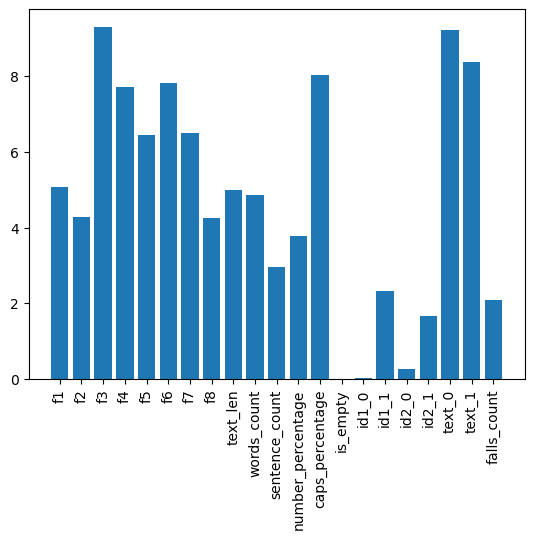

In [202]:
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xticks(rotation=90)
plt.show()